gen	nevals	avg  	min	max
0  	0     	1.712	0  	10 
1  	397   	2.732	0  	10 
2  	399   	3.69 	0  	11 
3  	398   	4.43 	0  	11 
4  	409   	4.988	0  	13 
5  	402   	5.808	0  	14 
6  	393   	6.568	0  	17 
7  	412   	7.012	0  	17 
8  	391   	7.778	0  	19 
9  	393   	8.51 	0  	19 
10 	393   	9.288	0  	26 
11 	412   	10.064	0  	24 
12 	404   	11.472	0  	26 
13 	391   	11.818	0  	27 
14 	384   	12.742	0  	25 
15 	393   	13.634	0  	27 
16 	412   	14.914	0  	29 
17 	383   	15.546	0  	29 
18 	391   	16.174	0  	30 
19 	409   	17.274	0  	32 
20 	393   	18.572	0  	32 
21 	391   	18.354	0  	34 
22 	391   	18.738	0  	35 
23 	391   	20.658	0  	36 
24 	407   	21.668	0  	37 
25 	398   	22.038	0  	36 
26 	386   	22.354	0  	37 
27 	419   	22.658	0  	38 
28 	401   	22.75 	0  	38 
29 	386   	23.024	0  	40 
30 	373   	25.154	0  	40 
31 	383   	26.802	0  	40 
32 	385   	26.424	0  	40 
33 	380   	26.582	0  	40 
34 	405   	26.23 	0  	40 
35 	400   	26.78 	0  	40 
36 	386   	27.484	0  	40 
37 	378   	29.546	0  	40

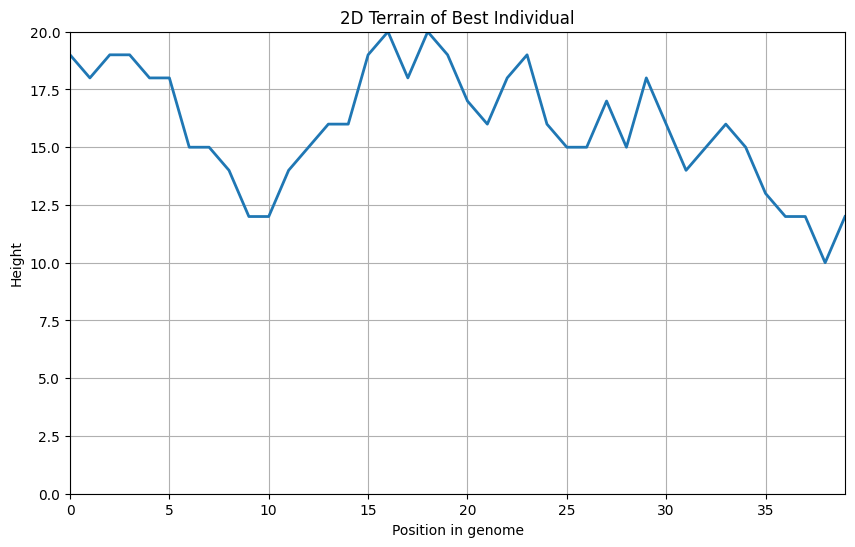

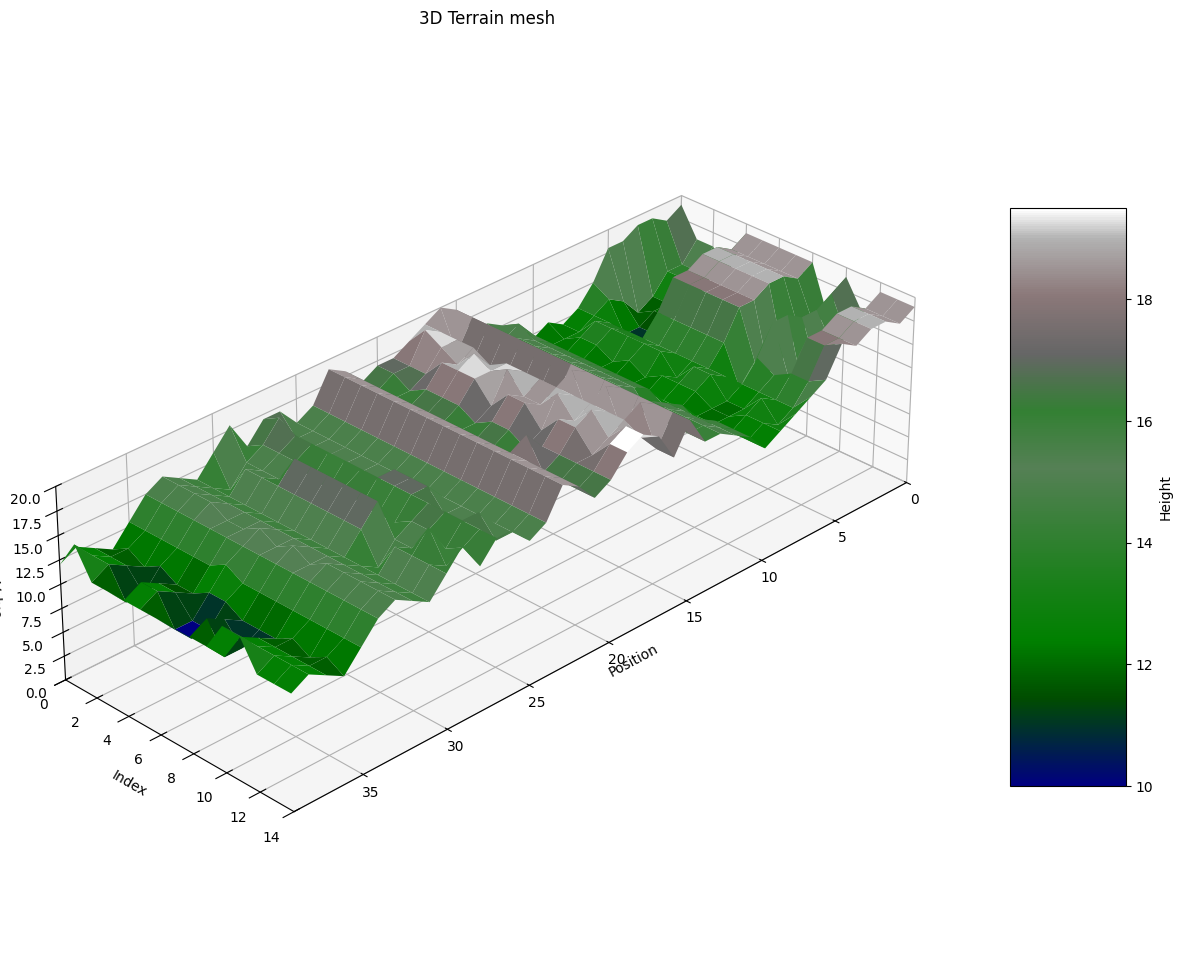

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from deap import base, creator, tools, algorithms
from matplotlib.colors import LinearSegmentedColormap

# ======================================================================================
# konfiguracia terenu
# ======================================================================================
GENOME_LENGTH = 40      # dlzka genomu terenu
MIN_HEIGHT = 0          # minimalna hodnota vysky
MAX_HEIGHT = 20         # maximalna hodnota vysky

# ======================================================================================
# parametre genetickeho algoritmu
# ======================================================================================
POPULATION_SIZE = 500       # pocet jedincov v populacii
MUTATION_RATE = 0.3         # pravdepodobnost mutacie
CROSSOVER_RATE = 0.7        # pravdepodobnost krizenia
TOURNAMENT_SIZE = 3         # velkost turnajovej selekcie
ELITISM_SIZE = 15           # pocet najlepsich jedincov na uchovanie
EVALUATION_DIFFERENCE = 1.2 # faktor rozsahu pre hodnotenie fitness
MAX_GENERATIONS = 200       # pocet generacii na beh
# ======================================================================================
# vymaz existujuce triedy deap aby neboli chyby
# ======================================================================================
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# vytvor triedy fitness a individual pre deap
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# ======================================================================================
# fitness funkcia
# ======================================================================================
def sophisticated_fitness_function(individual):
    # hodnotenie hladkosti terenu kontrolou rozdielov vysky susedov
    score = 0
    variable = EVALUATION_DIFFERENCE
    genome = individual
    
    # kontrola nasledujuceho suseda prveho prvku
    if (genome[1] >= genome[0] / variable and 
        genome[1] <= genome[0] * variable):
        score += 1
    
    # kontrola predosleho a nasledujuceho suseda strednych prvkov
    for i in range(1, len(genome) - 1):
        if (genome[i - 1] >= genome[i] / variable and 
            genome[i - 1] <= genome[i] * variable and 
            genome[i + 1] >= genome[i] / variable and 
            genome[i + 1] <= genome[i] * variable):
            score += 1
    
    # kontrola predosleho suseda posledneho prvku
    if (genome[-2] >= genome[-1] / variable and 
        genome[-2] <= genome[-1] * variable):
        score += 1
    
    return score,

# ======================================================================================
# inicializacia deap toolboxu
# ======================================================================================
toolbox = base.Toolbox()

# registracia funkcii pre generovanie genov, jedincov a populacie
toolbox.register("gene_maker", random.randint, MIN_HEIGHT, MAX_HEIGHT)
toolbox.register("individual_creator", tools.initRepeat, creator.Individual, 
                 toolbox.gene_maker, n=GENOME_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual_creator)

# registracia operatorov genetickeho algoritmu
toolbox.register("evaluate", sophisticated_fitness_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=MIN_HEIGHT, up=MAX_HEIGHT, 
                 indpb=CROSSOVER_RATE)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
toolbox.register("elitism", tools.selBest, k=ELITISM_SIZE)

# inicializacia sledovania statistik
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)  # sledovanie priemerneho fitness
stats.register("min", np.min)   # sledovanie minimaly fitness
stats.register("max", np.max)   # sledovanie maximaly fitness

# ======================================================================================
# main
# ======================================================================================
if __name__ == "__main__":
    # vytvorenie pociatocnej populacie
    population = toolbox.population(n=POPULATION_SIZE)
    
    # hodnotenie fitness pre vsetkych jedincov
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # vytvorenie hall of fame - vip zona pre najlepsich
    hof = tools.HallOfFame(ELITISM_SIZE)
    
    # spustenie genetickeho algoritmu
    algorithms.eaSimple(population, 
                        toolbox,
                        cxpb=CROSSOVER_RATE,
                        mutpb=MUTATION_RATE,
                        ngen=MAX_GENERATIONS,
                        stats=stats,
                        halloffame=hof,
                        verbose=True)
    
    # extrahovanie najlepsieho jedinca z populacie
    best_individual = tools.selBest(population, 1)[0]

    # vypis vysledkov
    # print("HallOfFame:", hof)
    print("Best individual:", best_individual)
    print("Best individual fitness:", best_individual.fitness.values[0])
    
    # definovanie vlastnej farebnej mapy pre vysky terenu
    colors = [
        (0.0, (0.0, 0.0, 0.5)),         # 0% - tmavomodra
        (0.15, (0.0, 0.3, 0.0)),        # 15% - tmavozelena
        (0.25, (0.0, 0.5, 0.0)),        # 25% - zelena
        (0.35, (0.1, 0.5, 0.1)),        # 35% - svetlozelena
        (0.55, (0.333, 0.5, 0.333)),    # 55% - zelenosiva
        (0.65, (0.2, 0.5, 0.2)),        # 65% - stredne zelena
        (0.75, (0.4, 0.4, 0.4)),        # 75% - siva
        (0.85, (0.545, 0.471, 0.475)),  # 85% - hnedosiva
        (0.95, (0.7, 0.7, 0.7)),        # 95% - svetlosiva
        (1.0, (1.0, 1.0, 1.0))          # 100% - biela
    ]
    cmap = LinearSegmentedColormap.from_list('terrain_cmap', [(p, c) for p, c in colors])

    # vytvorenie 2D grafu pre najlepsieho jedinca
    fig_2d = plt.figure(figsize=(10, 6))
    ax_2d = fig_2d.add_subplot(111)
    
    # priprava dat pre 2D ciarovy graf
    x = np.arange(GENOME_LENGTH)
    y = np.array(best_individual)
    
    # vykreslenie ciary s predvolenou farbou
    ax_2d.plot(x, y, linewidth=2)
    
    # nastavenie labels a nazvu
    ax_2d.set_xlabel('Position in genome')
    ax_2d.set_ylabel('Height')
    ax_2d.set_title('2D Terrain of Best Individual')
    
    # nastavenie limitov os(i)
    ax_2d.set_xlim(0, GENOME_LENGTH - 1)
    ax_2d.set_ylim(MIN_HEIGHT, MAX_HEIGHT)
    
    # pridanie mriezky pre lepsiu citatelnost
    ax_2d.grid(True)
    
    # vykreslenie 3D grafu
    fig_3d = plt.figure(figsize=(15, 15))
    ax_3d = fig_3d.add_subplot(111, projection='3d')  # jeden 3d subplot (1x1 grid)

    # priprava dat pre graf
    x_3d = np.arange(GENOME_LENGTH)
    y_3d = np.arange(ELITISM_SIZE)
    X, Y = np.meshgrid(x_3d, y_3d)
    Z = np.array([hof[i] for i in range(ELITISM_SIZE)])

    # nakreslenie s farbou
    surf = ax_3d.plot_surface(X, Y, Z, cmap=cmap, edgecolor='none')

    # set axis labels and title
    ax_3d.set_xlabel('Position')
    ax_3d.set_ylabel('Index')
    ax_3d.set_zlabel('Value')
    ax_3d.set_title('3D Terrain mesh')

    # nastavit limity os
    ax_3d.set_xlim(0, GENOME_LENGTH - 1)
    ax_3d.set_ylim(0, ELITISM_SIZE - 1)
    ax_3d.set_zlim(MIN_HEIGHT, MAX_HEIGHT)

    # vyrovnanie proporcii
    ax_3d.set_box_aspect((GENOME_LENGTH, ELITISM_SIZE, MAX_HEIGHT * 0.5))

    # nastavenie uhla pohladu pre lepsiu perspektivu
    ax_3d.view_init(elev=30, azim=45)

    # pridanie farebneho pruhu 
    fig_3d.colorbar(surf, ax=ax_3d, label='Height', shrink=0.5, aspect=5)

    # ukaz grafy
    plt.show()